In [12]:
#!/usr/bin/env python3
import tensorflow as tf

import os
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

from src.ForecastModel.utils.metrics import (calculate_nse, calculate_kge, calculate_bias, load_metrics,
                                             calculate_bias_flv, calculate_bias_fhv,
                                            )
from src.ForecastModel.utils.postprocessing import ModelHandler

import numpy as np
import pandas as pd

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 6,
})

In [13]:
PLOT_PATH = r"plots"
DATA_PATH = r"src\data\Dataset.csv"

In [41]:
models = {
    "arima": ModelHandler("ARIMA",
                r"rst\ARIMA",
                is_final_model = True,
                is_external_model = True,
                color = "#ff7f00",
                ls = "-",
                  ),
     "elstm": ModelHandler("eLSTM",
                   r"rst\eLSTM",
                   is_final_model = True,
                   color = '#984ea3',
                   ls = "-",
                 ),
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
               r"rst\PBHM-HLSTM",
               is_final_model = True,
               color = "#e41a1c",
               ls = "-",
              )
     }

In [42]:
# calculate metrics of hydrologic model per fold
dfh = pd.read_csv(DATA_PATH, parse_dates=['time'])

hyd_metrics = {}
for year in range(2012, 2018):
      dfp = dfh.loc[dfh["time"].dt.year == year]
      hyd_metrics[year] = {
          "kge":  calculate_kge(dfp.qmeasval.values, dfp.qsim.values),
          "nse":  calculate_nse(dfp.qmeasval.values, dfp.qsim.values),
          "bias": calculate_bias(dfp.qmeasval.values, dfp.qsim.values),
          "fhv": calculate_bias_fhv(dfp.qmeasval.values, dfp.qsim.values),
          "flv": calculate_bias_flv(dfp.qmeasval.values, dfp.qsim.values),
      }    
    

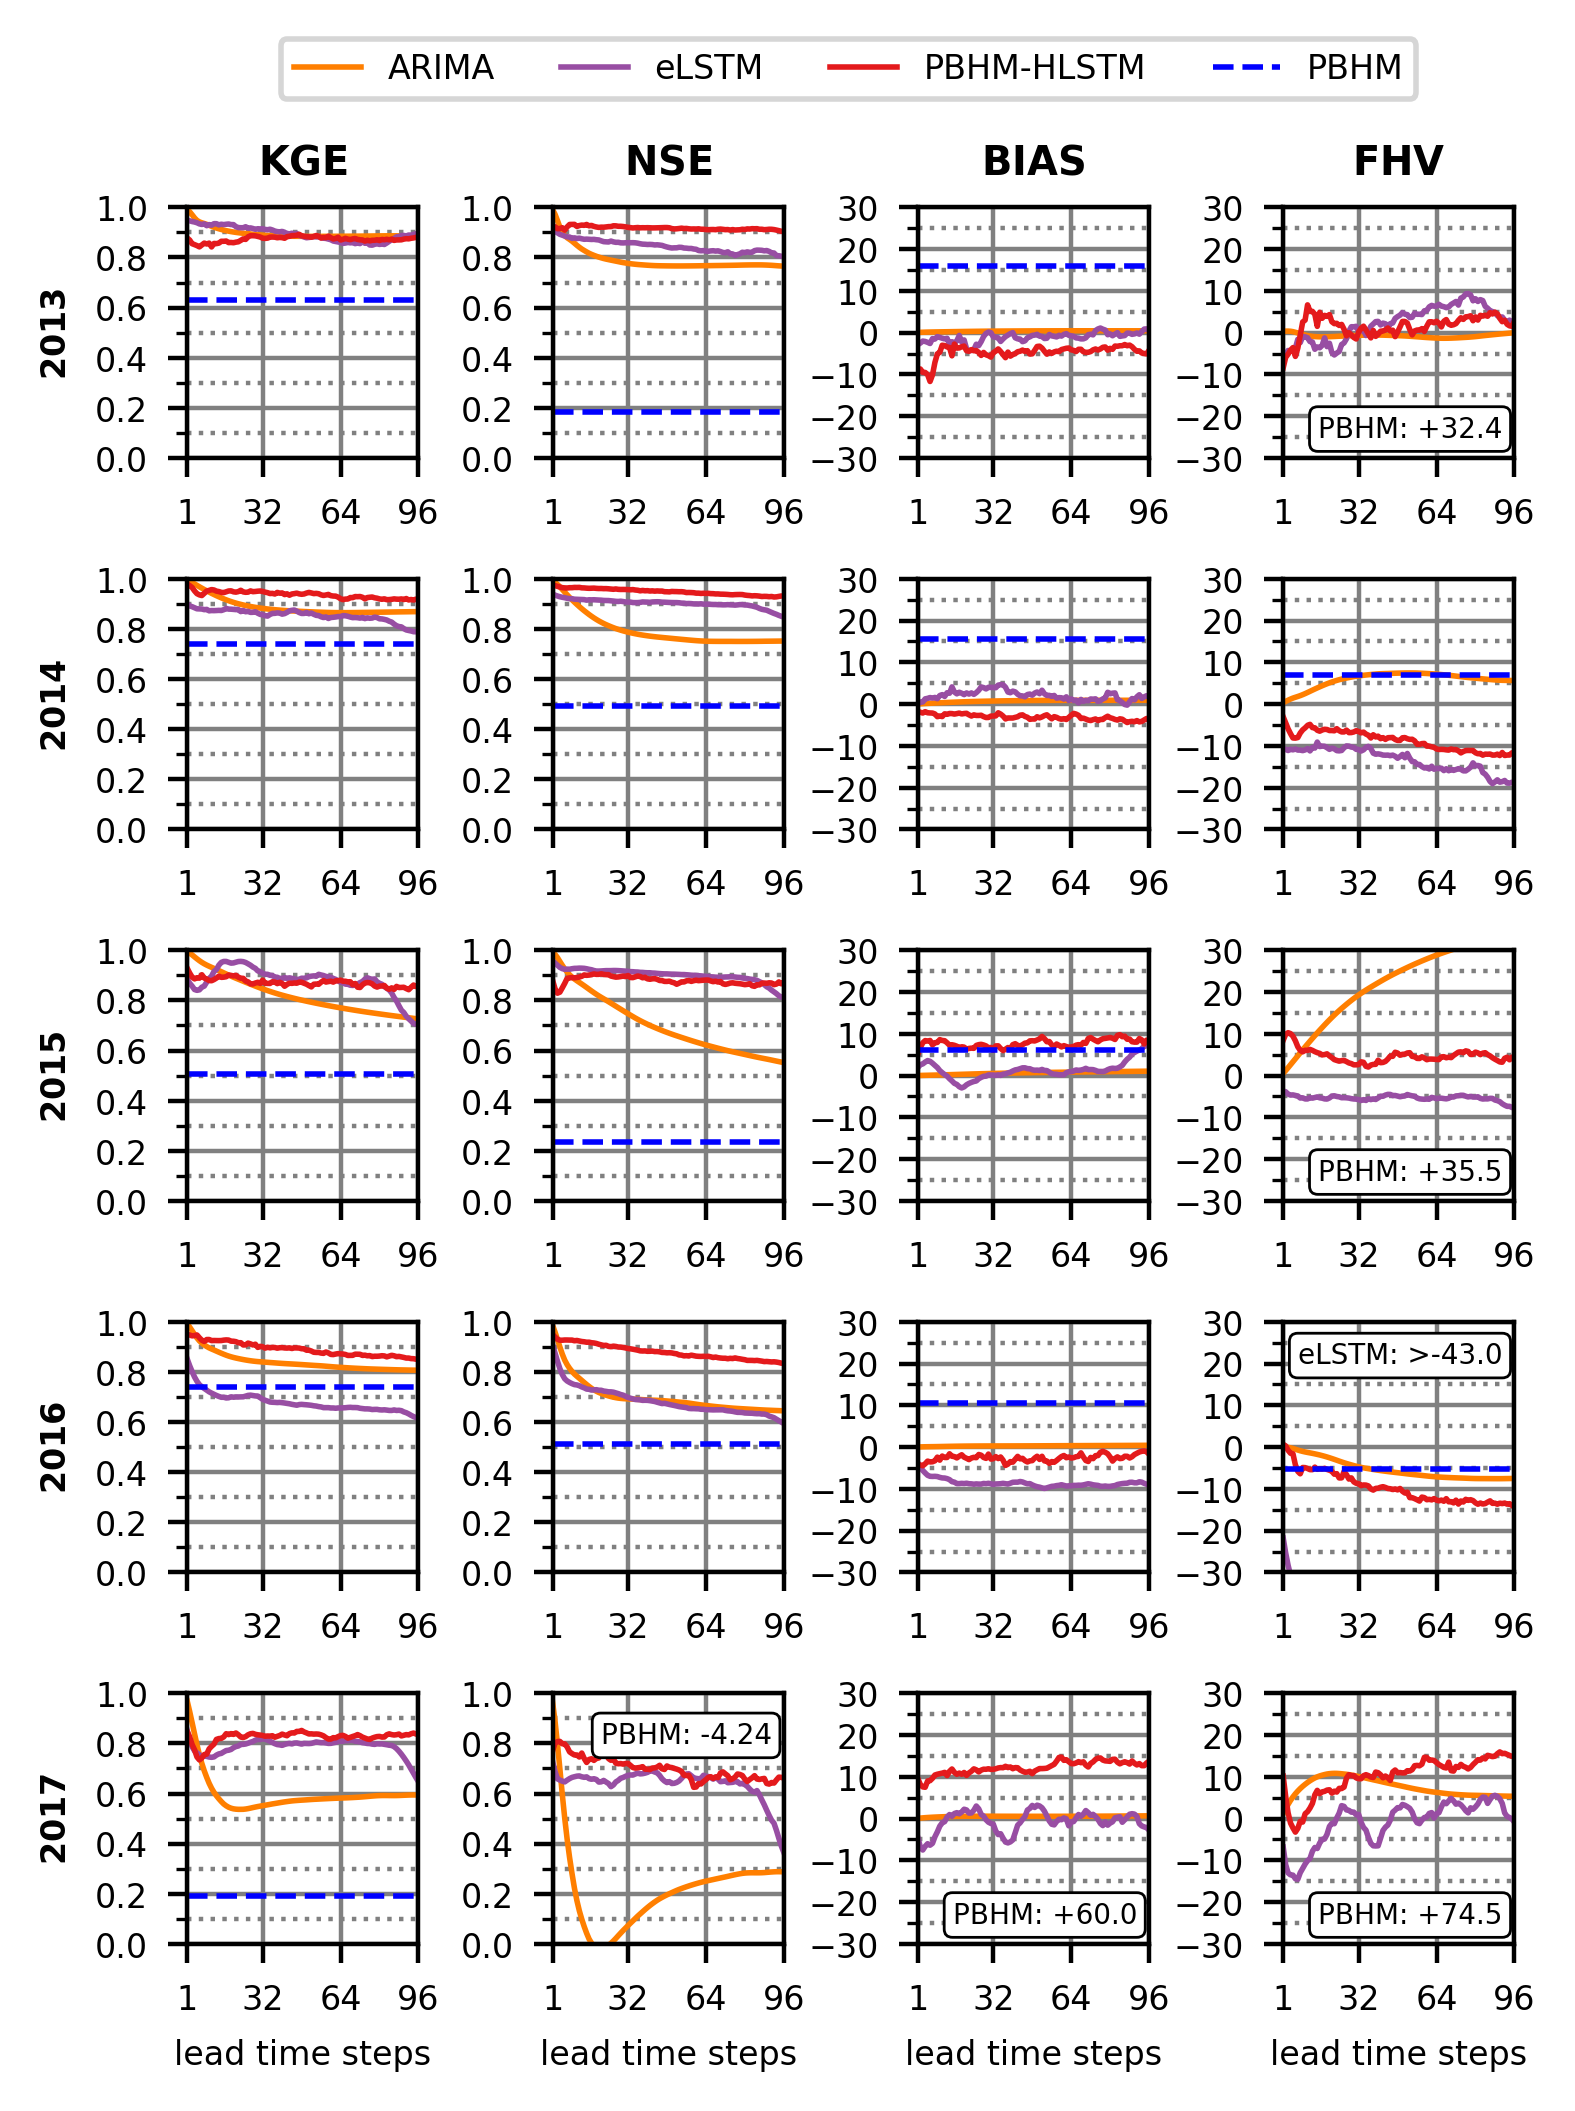

In [91]:
fig, axes = plt.subplots(5,4,figsize=(4.72,5), dpi=400)

metric_names = ["kge", "nse", "bias", "fhv"]
metric_labels = ["KGE", "NSE", "BIAS", "FHV"]
ylims = [(0,1), (-2,1)]


xx = np.arange(1,97)
df = pd.DataFrame(columns=["name", "year", 
                           "kge_min", "kge_avg", "kge_max", 
                           "nse_min", "nse_avg", "nse_max", 
                          ])

n_row = -5
for n, key in enumerate(models.keys()):
    metrics = load_metrics(os.path.join(models[key].lg_path, "metrics_eval.txt"))
    
    n_row += 5
    for j, met in enumerate(metric_names):
        metric  = metrics["test"][met]
        for i in range(5):
            df.loc[n_row+i, ["name", "year"]] = [models[key].name, 2013+i]
            df.loc[n_row+i, [f"{met}_min", f"{met}_avg", f"{met}_max"]] = [np.min(metric[i]), 
                                                                           np.mean(metric[i]), 
                                                                           np.max(metric[i])]
            df.loc[n_row+i, [f"{met}_{x}" for x in range(96)]] = [metric[i][x] for x in range(96)]
            xx = np.arange(1,np.array(metric[i]).shape[0]+1)
            axes[i,j].plot(xx, metric[i], color=models[key].color, ls=models[key].ls, label=f"{models[key].name}", lw=1)


for i in range(5):
    for j, met in enumerate(metric_names):
        if i == 0:
            axes[i,j].set_title(r"$\bf{"+f"{metric_labels[j]}"+r"}$")
        elif i == 4:
            axes[i,j].set_xlabel("lead time steps")
        if j == 0:
            axes[i,j].set_ylabel(r"$\bf{"+f"{2013 + i}"+r"}$")

        axes[i,j].hlines(hyd_metrics[2013+i][metric_names[j]], 1, 96, color="b", ls = "--", label="PBHM", lw=1)
        if (i == 4) & (j == 1):
            metric_hyd = hyd_metrics[2013+i][metric_names[j]]
            axes[i,j].text(91,0.8, f"PBHM: {metric_hyd:+4.2f}", color="k", ha="right", fontsize=5,
                     bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                               "lw": 0.5,
                     })
        if (i == 4) & (j == 2):
            metric_hyd = hyd_metrics[2013+i][metric_names[j]]
            axes[i,j].text(91,-25, f"PBHM: {metric_hyd:+4.1f}", color="k", ha="right", fontsize=5,
                     bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                               "lw": 0.5,
                     })
        
        if (i in [0, 2, 4]) & (j == 3):
            metric_hyd = hyd_metrics[2013+i][metric_names[j]]
            axes[i,j].text(91,-25, f"PBHM: {metric_hyd:+4.1f}", color="k", ha="right", fontsize=5,
                     bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                               "lw": 0.5,
                     })

        if (i == 3) & (j == 3):
            metric = df.loc[df.name=="eLSTM"].filter(regex="fhv_[0-9]").min(axis=1).values[3] # get value from df
            axes[i,j].text(91,20, f"eLSTM: >{metric:+4.1f}", color="k", ha="right", fontsize=5,
                     bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                               "lw": 0.5,
                     })
            
            
            
        axes[i,j].set_xticks([1,32,64,96])
        if j in [2, 3]:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(10))
            axes[i,j].yaxis.set_minor_locator(MultipleLocator(5))
            axes[i,j].set_ylim((-30,30))
        else:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(0.2))
            axes[i,j].yaxis.set_minor_locator(MultipleLocator(0.1))
            axes[i,j].set_ylim((0,1))

        axes[i,j].set_xlim((1,96))
        
        axes[i,j].grid(which='major', color='grey', linestyle='-')
        axes[i,j].grid(which='minor', color='grey', linestyle=':')


fig.tight_layout()
plt.subplots_adjust(right = 0.8)
axes[0,2].legend(bbox_to_anchor=(-0.3, 1.3), 
                 loc='lower center', ncol=4, 
                 borderaxespad=1)


In [92]:
# save figure
fig.savefig(os.path.join(PLOT_PATH, 'fig5_leadtime_performance.png'), bbox_inches="tight", dpi=300)

In [87]:
df

,name,year,kge_min,kge_avg,kge_max,nse_min,nse_avg,nse_max,kge_0,kge_1,...,fhv_86,fhv_87,fhv_88,fhv_89,fhv_90,fhv_91,fhv_92,fhv_93,fhv_94,fhv_95
0,ARIMA,2013,0.883965,0.896109,0.992364,0.765174,0.790791,0.991315,0.992364,0.982365,...,-0.508383,-0.450898,-0.392185,-0.333391,-0.279187,-0.226470,-0.174485,-0.119900,-0.065469,-0.011318
1,ARIMA,2014,0.865033,0.887936,0.995619,0.75018,0.794716,0.99437,0.995619,0.990508,...,5.839719,5.793820,5.756343,5.726351,5.702725,5.688428,5.673891,5.663186,5.653661,5.640614
2,ARIMA,2015,0.726017,0.820014,0.995044,0.551945,0.702966,0.994329,0.995044,0.988826,...,32.999737,33.182716,33.365608,33.553377,33.746005,33.940589,34.132818,34.322829,34.512989,34.700103
3,ARIMA,2016,0.80667,0.840894,0.992716,0.644688,0.701259,0.98698,0.992716,0.978978,...,-7.557014,-7.559073,-7.561154,-7.560228,-7.555019,-7.545778,-7.536069,-7.526054,-7.513581,-7.501014
4,ARIMA,2017,0.536915,0.596397,0.968628,-0.018164,0.221863,0.965589,0.968628,0.927472,...,5.462501,5.446501,5.427503,5.410554,5.396389,5.384881,5.373468,5.363405,5.352435,5.340759
5,eLSTM,2013,0.849049,0.894369,0.947633,0.802678,0.845648,0.911951,0.947633,0.946195,...,5.042102,4.746700,4.080130,3.641682,3.761315,2.994902,2.493076,2.984732,2.661494,0.937166
6,eLSTM,2014,0.787249,0.853864,0.900123,0.84717,0.902426,0.939621,0.900123,0.891795,...,-19.048086,-18.624189,-18.124078,-18.688425,-18.565724,-18.284430,-18.905110,-18.926182,-18.699495,-18.912759
7,eLSTM,2015,0.704111,0.877162,0.955778,0.810921,0.901531,0.959337,0.885573,0.868765,...,-5.454429,-5.842546,-5.994163,-6.245912,-6.733300,-7.077306,-7.358808,-7.348756,-7.619036,-7.830905
8,eLSTM,2016,0.614212,0.679236,0.851625,0.594231,0.684377,0.908311,0.851625,0.824818,...,-40.056695,-39.927512,-40.095665,-40.536097,-40.885947,-41.165860,-41.615674,-42.140885,-42.573448,-42.981597
9,eLSTM,2017,0.647341,0.786206,0.850612,0.365707,0.638627,0.727888,0.850612,0.813800,...,5.365294,5.573245,5.319898,4.747442,3.638897,1.355096,0.519316,0.258325,-0.052602,-0.875328
